## Evaluation

In [1]:
import pandas as pd
import numpy as np
from keras.models import load_model

Using TensorFlow backend.


In [2]:
model = load_model('Models/WholeModel.h5')

/home/ubuntu/.local/lib/python2.7/site-packages/keras/engine/topology.py:1242: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


In [3]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 51)            0                                            
____________________________________________________________________________________________________
input_1 (InputLayer)             (None, 1000)          0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 51, 256)       11401472    input_2[0][0]                    
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 128)           128128      input_1[0][0]                    
___________________________________________________________________________________________

In [4]:
from pycocotools.coco import COCO

In [5]:
annFile_train = "annotations/captions_train2014.json"

coco = COCO(annFile_train)

loading annotations into memory...
Done (t=1.95s)
creating index...
index created!


In [6]:
imgIds = coco.getImgIds()
annIds = coco.getAnnIds(imgIds)

imgs = coco.loadImgs(imgIds)
anns = coco.loadAnns(annIds)

In [7]:
imgs_df = pd.DataFrame(imgs)
anns_df = pd.DataFrame(anns)

In [8]:
img_new = imgs_df.drop(['coco_url','date_captured','flickr_url','height','width','license'], axis=1)

img_new.rename(columns={'id': 'image_id'}, inplace=True)

anns_df['caption'] = anns_df['caption'].apply(lambda x: '<start>' + x + '<end>')

df = pd.merge(anns_df, img_new, on='image_id', how='left')

In [9]:
df.drop(['id'], axis=1, inplace=True)

In [10]:
df.head()

,caption,image_id,file_name
0,<start>People shopping in an open market for v...,262145,COCO_train2014_000000262145.jpg
1,<start>An open market full of people and piles...,262145,COCO_train2014_000000262145.jpg
2,<start>People are shopping at an open air prod...,262145,COCO_train2014_000000262145.jpg
3,<start>Large piles of carrots and potatoes at ...,262145,COCO_train2014_000000262145.jpg
4,<start>People shop for vegetables like carrots...,262145,COCO_train2014_000000262145.jpg


In [11]:
img_files = set(df['file_name'])

In [12]:
len(img_files)

82783

In [13]:
from picturedata.generator import DataGenerator

In [14]:
generator = DataGenerator()

Total samples : 4745052
Vocabulary size: 44537
Maximum caption length: 51


In [15]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image, sequence
from imagenet_utils import preprocess_input


In [16]:
img_dir = "images/"
images = []
c = 0
for img_file in img_files:
    c += 1
    img = image.load_img(img_dir + img_file, target_size=(224, 224))
    images.append(img)
    if c == 100:
        break

In [17]:
modelVGG = VGG16(weights='imagenet', include_top=True, input_shape = (224, 224, 3))

c = 0
img_features = []
for img in images:
    c += 1
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = np.asarray(img)
    img_feature = modelVGG.predict(img)
    #img_feature = np.asarray(img_feature)
    #img_feature = img_feature.argmax(axis=-1)
    if c % 100 == 0:
        print "Processed {0} images".format(c)
        break
    img_features.append(img_feature[0])
img_features = np.asarray(img_features)

Processed 100 images


In [19]:
image_feature = img_features[3]
start = [generator.word_index['<start>']]
captions = [[start, 0.0]]
while(len(captions[0][0]) < generator.max_cap_len):
    temp_captions = []
    for caption in captions:
        partial_caption = sequence.pad_sequences([caption[0]], maxlen=generator.max_cap_len, padding='post')
        next_words_pred = model.predict([np.asarray([image_feature]), np.asarray(partial_caption)])[0]
        next_words = np.argsort(next_words_pred)[-3:]
        for word in next_words:
            new_partial_caption, new_partial_caption_prob = caption[0][:], caption[1]
            new_partial_caption.append(word)
            new_partial_caption_prob+=next_words_pred[word]
            temp_captions.append([new_partial_caption,new_partial_caption_prob])
    
    captions = temp_captions
    captions.sort(key = lambda l:l[1])
    captions = captions[-3:]

    
captions.sort(key = lambda l:l[1])
best_caption = captions[-1][0]
caption = " ".join([generator.index_word[index] for index in best_caption])

caption_split = caption.split()
processed_caption = caption_split[1:]

try:
    end_index = processed_caption.index('<end>')
    processed_caption = processed_caption[:end_index]
except:
    pass
print " ".join([word for word in processed_caption])



A group of zebras are standing in the grass.


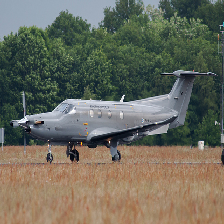

In [38]:
images[0]

In [60]:
image_feature = img_features[1]
start = [generator.word_index['<start>']]
captions = [[start, 0.0]]
partial_caption = sequence.pad_sequences([captions[0][0]], maxlen=generator.max_cap_len, padding='post')
next_words_pred = model.predict([np.asarray([image_feature]), np.asarray(partial_caption)])[0]
print next_words_pred[33541]
print np.argsort(next_words_pred)[-3:]

image_feature = img_features[95]
start = [generator.word_index['<start>']]
captions = [[start, 0.0]]
partial_caption = sequence.pad_sequences([captions[0][0]], maxlen=generator.max_cap_len, padding='post')
next_words_pred = model.predict([np.asarray([image_feature]), np.asarray(partial_caption)])[0]
print next_words_pred[33541]
print np.argsort(next_words_pred)[-3:]


0.689029
[15577 37587 33541]
0.687155
[15577 37587 33541]


In [59]:
next_words_pred[33541]

0.68715531